In [1]:
####################################################################################
# Explainable AI - Airbnb Booking Rate Model
# training and XAI
# sean x wang
####################################################################################
import time
from scipy import stats
import datetime
import s3fs
import statistics
import decimal
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

import pandas as pd, numpy as np, os, random, math, matplotlib, pylab, scipy, gc

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor

random.seed(1)
np.random.seed(1)
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter
import shap
import eli5
import lime
from lime.lime_tabular import LimeTabularExplainer
shap.initjs()

# Prepare data

In [3]:
from AirbnbDataPrep import getBookingData

In [4]:
# use LA area data for the example
calendarA_url = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-03-06/data/calendar.csv.gz'
calendarB_url = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/data/calendar.csv.gz'
listings_url = 'http://data.insideairbnb.com/united-states/ca/los-angeles/2019-12-05/data/listings.csv.gz'

date_B = datetime.datetime(2019, 12, 6)
df = getBookingData(calendarB_url, calendarA_url, listings_url, date_B)
print(df.shape)
df.head()

calendar B (14670849, 6)
The dataset contains 40125 Airbnb listings
do nothing for nan
(33046, 87)


booking_score  host_response_time  host_response_rate  \
id                                                            
2708       0.580645                 5.0               100.0   
2732       0.677419                 5.0               100.0   
5728       0.258065                 1.0               100.0   
5729       0.677419                 1.0               100.0   
5843       0.733333                 1.0               100.0   

      host_is_superhost  host_listings_count  host_has_profile_pic  \
id                                                                   
2708                1.0                  2.0                   1.0   
2732                1.0                  2.0                   1.0   
5728                1.0                  8.0                   1.0   
5729                1.0                  8.0                   1.0   
5843                1.0                  8.0                   1.0   

      host_identity_verified neighbourhood_cleansed  latitude  longitude  ...  \
id                                                                        ...   
2708                     1.0              Hollywood  34.09768 -118.34602  ...   
2732                     0.0           Santa Monica  34.00475 -118.48127  ...   
5728                     0.0                Del Rey  33.98833 -118.43224  ...   
5729                     0.0                Del Rey  33.98685 -118.43266  ...   
5843                     0.0                Del Rey  33.98782 -118.43170  ...   

      pets_allowed private_entrance secure  self_check_in  smoking_allowed  \
id                                                                           
2708           NaN              NaN    1.0            NaN              NaN   
2732           NaN              NaN    NaN            NaN              NaN   
5728           NaN              1.0    NaN            NaN              NaN   
5729           NaN              1.0    NaN            NaN              NaN   
5843           NaN              NaN    NaN            1.0              NaN   

      accessible  event_suitable days_as_host  days_since_first_review  \
id                                                                       
2708         1.0             NaN       4098.0                   2006.0   
2732         NaN             NaN       4097.0                   3105.0   
5728         NaN             NaN       3928.0                   3794.0   
5729         NaN             NaN       3928.0                   3749.0   
5843         NaN             NaN       3928.0                   3125.0   

      days_since_last_review  
id                            
2708                    97.0  
2732                    64.0  
5728                     9.0  
5729                    16.0  
5843                    14.0  

[5 rows x 87 columns]

In [101]:
s = df.sort_values(by='booking_score')
s[:100]

booking_score  host_response_time  host_response_rate  \
id                                                                
40603848            0.0                 5.0                88.0   
4165435             0.0                20.0                90.0   
19809182            0.0                 1.0               100.0   
8274248             0.0                 NaN                 NaN   
4211034             0.0                 1.0               100.0   
...                 ...                 ...                 ...   
32790595            0.0                 1.0                69.0   
32790737            0.0                 1.0                92.0   
19909962            0.0                 1.0               100.0   
32810602            0.0                 1.0               100.0   
8570560             0.0                 5.0                89.0   

          host_is_superhost  host_listings_count  host_has_profile_pic  \
id                                                                       
40603848                0.0                  5.0                   1.0   
4165435                 1.0                  1.0                   1.0   
19809182                0.0                 58.0                   1.0   
8274248                 0.0                  1.0                   1.0   
4211034                 1.0                  2.0                   1.0   
...                     ...                  ...                   ...   
32790595                0.0                  4.0                   1.0   
32790737                0.0                  4.0                   1.0   
19909962                1.0                  7.0                   1.0   
32810602                1.0                 28.0                   1.0   
8570560                 0.0                  7.0                   1.0   

          host_identity_verified neighbourhood_cleansed  latitude  longitude  \
id                                                                             
40603848                     0.0        University Park  34.03379 -118.28859   
4165435                      1.0               Downtown  34.05145 -118.25903   
19809182                     1.0               Downtown  34.04436 -118.25337   
8274248                      0.0                Compton  33.89987 -118.22390   
4211034                      0.0                Topanga  34.04115 -118.56894   
...                          ...                    ...       ...        ...   
32790595                     1.0              Echo Park  34.07397 -118.26458   
32790737                     1.0              Brentwood  34.05065 -118.46278   
19909962                     0.0            Studio City  34.13448 -118.40853   
32810602                     0.0           Santa Monica  34.00966 -118.49427   
8570560                      1.0              Hollywood  34.09914 -118.31068   

          ...  internet long_term_stays pets_allowed  private_entrance  \
id        ...                                                            
40603848  ...       1.0             NaN          NaN               NaN   
4165435   ...       1.0             NaN          NaN               NaN   
19809182  ...       1.0             NaN          1.0               NaN   
8274248   ...       1.0             NaN          1.0               NaN   
4211034   ...       1.0             NaN          NaN               NaN   
...       ...       ...             ...          ...               ...   
32790595  ...       1.0             NaN          NaN               NaN   
32790737  ...       1.0             1.0          NaN               1.0   
19909962  ...       1.0             NaN          NaN               NaN   
32810602  ...       1.0             NaN          1.0               NaN   
8570560   ...       1.0             NaN          NaN               NaN   

          secure  self_check_in  smoking_allowed accessible  event_suitable  \
id                                                                            
40603848     

LIME required fillna
use imputed data for LIME and SHAP for model consistency

In [6]:
# one hot encode
raw_data = pd.get_dummies(df)
print(raw_data.shape)

(33046, 412)


In [7]:
# fillna for LIME/Skater
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
data = pd.DataFrame(imp.fit_transform(raw_data))
data.columns = raw_data.columns
data.head()

booking_score  host_response_time  host_response_rate  host_is_superhost  \
0       0.580645                 5.0               100.0                1.0   
1       0.677419                 5.0               100.0                1.0   
2       0.258065                 1.0               100.0                1.0   
3       0.677419                 1.0               100.0                1.0   
4       0.733333                 1.0               100.0                1.0   

   host_listings_count  host_has_profile_pic  host_identity_verified  \
0                  2.0                   1.0                     1.0   
1                  2.0                   1.0                     0.0   
2                  8.0                   1.0                     0.0   
3                  8.0                   1.0                     0.0   
4                  8.0                   1.0                     0.0   

   latitude  longitude  is_location_exact  ...  \
0  34.09768 -118.34602                1.0  ...   
1  34.00475 -118.48127                1.0  ...   
2  33.98833 -118.43224                1.0  ...   
3  33.98685 -118.43266                1.0  ...   
4  33.98782 -118.43170                1.0  ...   

   jurisdiction_names_{Pasadena," CA"}  cancellation_policy_flexible  \
0                                  0.0                           0.0   
1                                  0.0                           0.0   
2                                  0.0                           0.0   
3                                  0.0                           0.0   
4                                  0.0                           0.0   

   cancellation_policy_luxury_moderate  cancellation_policy_luxury_no_refund  \
0                                  0.0                                   0.0   
1                                  0.0                                   0.0   
2                                  0.0                                   0.0   
3                                  0.0                                   0.0   
4                                  0.0                                   0.0   

   cancellation_policy_luxury_super_strict_95  cancellation_policy_moderate  \
0                                         0.0                           0.0   
1                                         0.0                           0.0   
2                                         0.0                           1.0   
3                                         0.0                           1.0   
4                                         0.0                           1.0   

   cancellation_policy_strict  \
0                         0.0   
1                         0.0   
2                         0.0   
3                         0.0   
4                         0.0   

   cancellation_policy_strict_14_with_grace_period  \
0                                              1.0   
1                                              1.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   cancellation_policy_super_strict_30  cancellation_policy_super_strict_60  
0                                  0.0                                  0.0  
1                                  0.0                                  0.0  
2                                  0.0                                  0.0  
3                                  0.0                                  0.0  
4                                  0.0                                  0.0  

[5 rows x 412 columns]

In [8]:
# clean up column names, replace space, remove all special char (avoid LIME bug)
data.columns = data.columns.str.replace(' ','_')
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '',)
data.columns.values

array(['booking_score', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'calendar_updated', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 

# Global XAI - SHAP

## train model

In [9]:
# use labeled version to get labeled global feature importance first
# use fillna version of data, to be consistent with LIME predictions
y = data['booking_score']
X = data.drop(['booking_score'], axis=1)

In [ ]:
# train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)
evalSet = [(X_train, y_train), (X_test, y_test)]

y_mean = np.mean(y_train)

xgb_model = XGBRegressor(objective='reg:logistic', 
                   eval_metric='mae',
                   learning_rate = 0.1, 
                   base_score=y_mean,
                   n_estimators=3000,
                   #min_child_weight=2,
                   subsample=0.8,
                   colsample_bytree=0.8,
                   reg_alpha=1,
                   reg_lambda=5,
                   max_depth = 5,
                   random_state=88)
                    
xgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evalSet, verbose=50)

# xgboost provides R2 score
print ("Training score:",xgb_model.score(X_train,y_train),"Test Score:",xgb_model.score(X_test,y_test))

In [40]:
test_pred = xgb_model.predict(X_test)
test_pred

array([0.63453525, 0.64150065, 0.03975307, ..., 0.56721085, 0.30380568,
       0.4711202 ], dtype=float32)

## xgboost feature analysis (for comparison)
How the importance is calculated: either “weight”, “gain”, or “cover”
”weight” is the number of times a feature appears in a tree
”gain” is the average gain of splits which use the feature
”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

In [41]:
eli5.show_weights(xgb_model.get_booster())

## SHAP feature analysis

In [42]:
# use labeled data set
shap_explainer = shap.TreeExplainer(xgb_model)
test_shap_values = shap_explainer.shap_values(X_test)
print('Expected Value:', shap_explainer.expected_value)
pd.DataFrame(test_shap_values).head()

Expected Value: -0.012485579


0         1         2         3         4         5         6    \
0  0.003445  0.034530  0.021506 -0.122136  0.000041 -0.004698 -0.328195   
1  0.000975  0.026822  0.084253  0.074921  0.000139 -0.017638  0.017585   
2 -0.007211  0.025355 -0.091981 -0.013180  0.000030  0.036195 -0.148389   
3 -0.087567 -0.159019 -0.058240 -0.163509  0.000027  0.006359 -0.071172   
4  0.039925  0.021763  0.072431 -0.106552  0.000036  0.012168  0.252680   

        7         8         9    ...       401       402       403  404  \
0 -0.102101 -0.006145  0.007809  ... -0.000296  0.004619  0.000019  0.0   
1  0.069093  0.000622  0.055434  ...  0.000217  0.005724  0.000027  0.0   
2  0.035043 -0.027942  0.063563  ...  0.000421  0.028185  0.000022  0.0   
3 -0.235344 -0.000352  0.078167  ...  0.001290 -0.004077 -0.000076  0.0   
4  0.212635  0.013419  0.077994  ...  0.000073 -0.007806  0.000043  0.0   

        405       406       407       408  409       410  
0 -0.000264  0.013747 -0.000020  0.021107  0.0 -0.000047  
1 -0.000227  0.037473 -0.000014 -0.004897  0.0 -0.000034  
2 -0.000251 -0.022537 -0.000075  0.010592  0.0 -0.000064  
3 -0.000276 -0.008315 -0.000181  0.028171  0.0 -0.000024  
4 -0.000244 -0.015063 -0.000046  0.013753  0.0 -0.000045  

[5 rows x 411 columns]

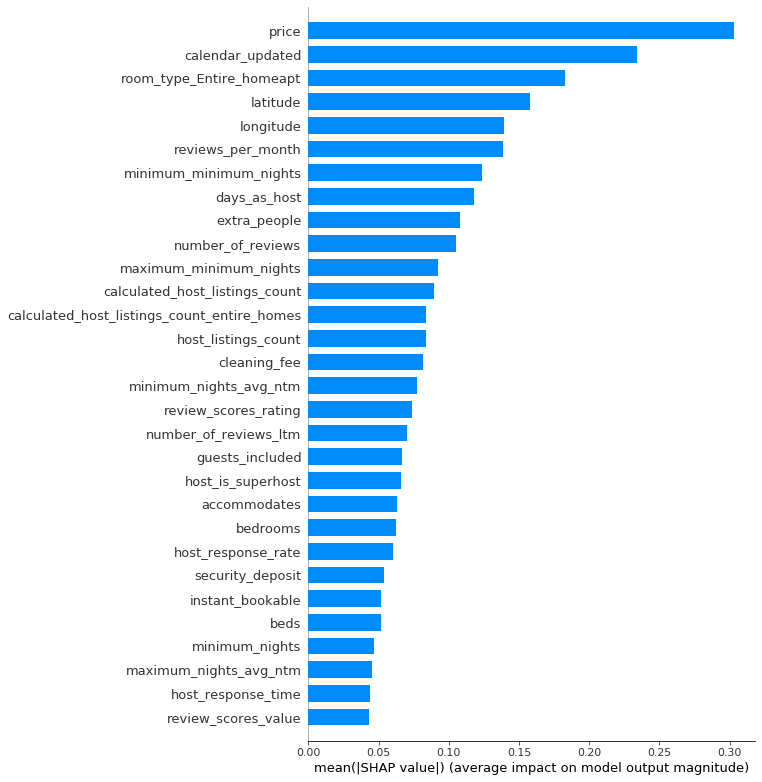

In [43]:
shap.summary_plot(test_shap_values, X_test, plot_type="bar", max_display=30)

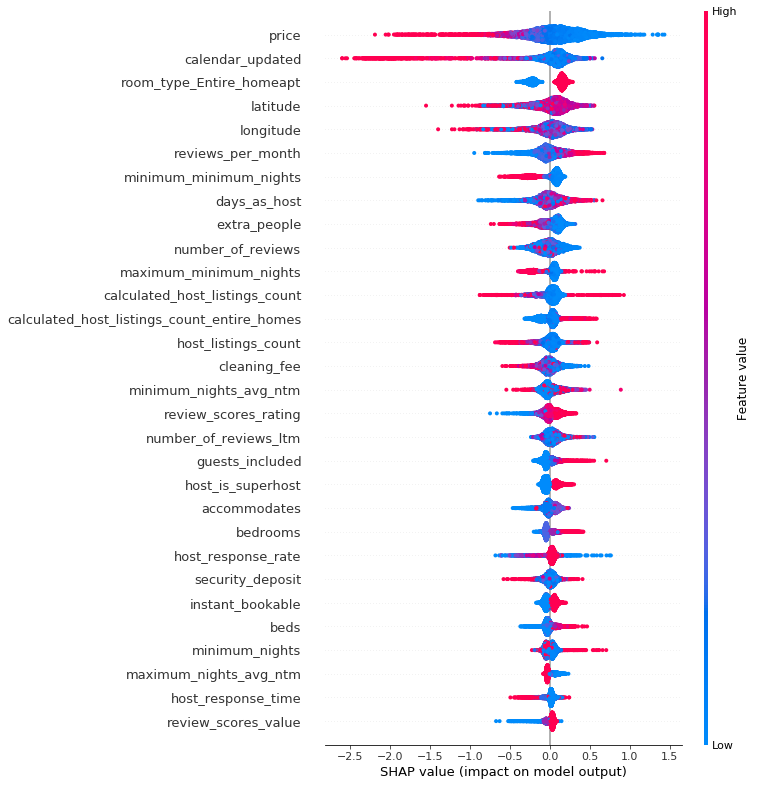

In [44]:
# shows feature contribution
shap.summary_plot(test_shap_values, X_test, max_display=30)

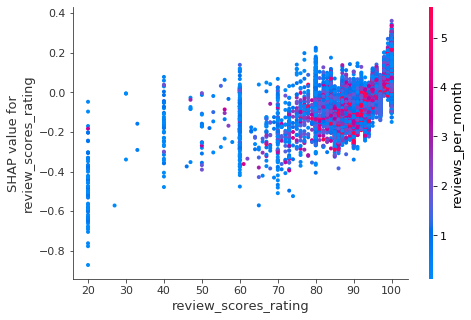

In [20]:
# *is it more important to get higher review score or more reviews?
shap.dependence_plot(ind='review_scores_rating', interaction_index='reviews_per_month',
                     xmax="percentile(95)",
                     shap_values=shap_values, 
                     features=X_train)

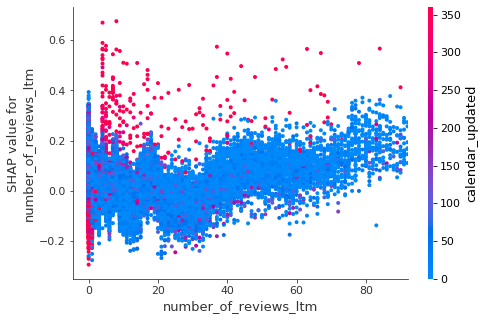

In [84]:
# *two types of hosts, stale listing, those who keep listing available
shap.dependence_plot(ind='number_of_reviews_ltm', 
                     #interaction_index='calendar_updated',
                     xmax="percentile(99)",
                     shap_values=shap_values, 
                     features=X_train)

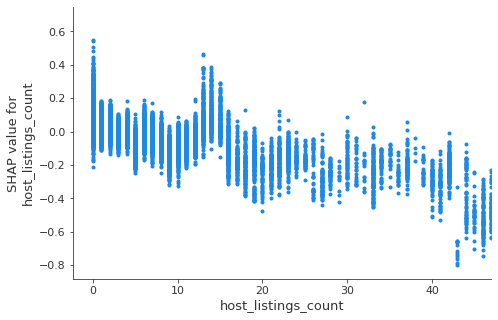

In [98]:
# those who have more listings () don't do better
shap.dependence_plot(ind='host_listings_count', 
                     interaction_index=None,
                     xmax="percentile(95)",
                     shap_values=shap_values, 
                     features=X_train)

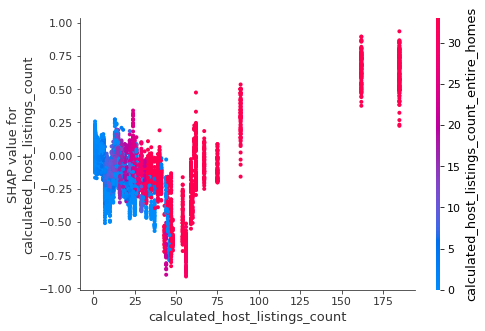

In [99]:
# but there are exceptions who gets incredible (professional mgmt) 
shap.dependence_plot(ind='calculated_host_listings_count', 
                     #interaction_index=None,
                     interaction_index='calculated_host_listings_count_entire_homes',
                     #xmax="percentile(95)",
                     shap_values=shap_values, 
                     features=X_train)

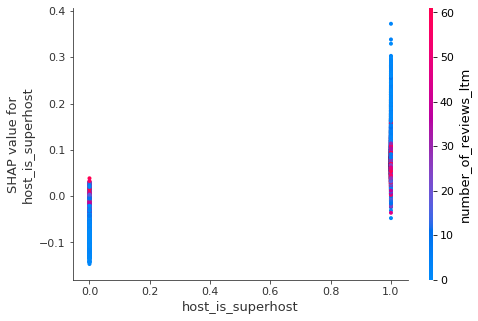

In [88]:
# does superhost do better than the rest?
shap.dependence_plot(ind='host_is_superhost', #interaction_index='host_is_superhost',
                     #xmax="percentile(95)",
                     shap_values=shap_values, 
                     features=X_train)

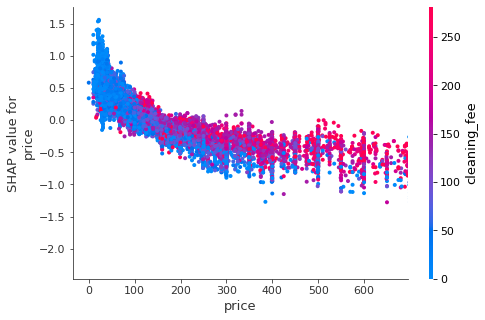

In [90]:
# *is it a good idea to charge a cleaning fee
shap.dependence_plot(ind='price', 
                     interaction_index='cleaning_fee',
                     xmax="percentile(95)",
                     shap_values=shap_values, 
                     features=X_train)

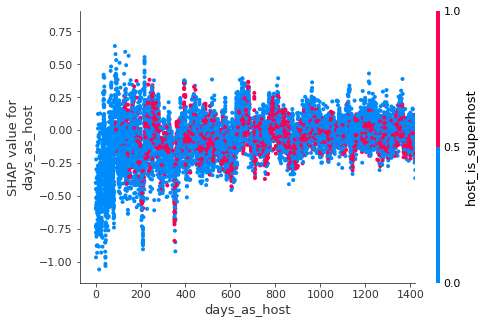

In [87]:
# how to become a superhost?
shap.dependence_plot(ind='days_as_host', interaction_index='host_is_superhost',
                     xmax="percentile(50)",
                     shap_values=shap_values, 
                     features=X_train)

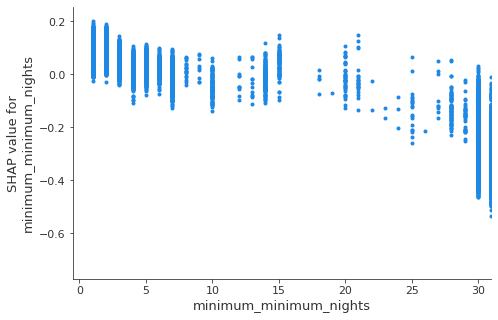

In [89]:
# 
shap.dependence_plot(ind='minimum_minimum_nights', 
                     interaction_index=None,
                     xmax="percentile(98)",
                     shap_values=shap_values, 
                     features=X_train)

# Local XAI

## local XAI with SHAP force plots

In [46]:
# plot the explanation for a single prediction
shap.force_plot(shap_explainer.expected_value, test_shap_values[0], X_test.iloc[0])

In [49]:
shap.force_plot(shap_explainer.expected_value, test_shap_values[1, :], X_test.iloc[1, :])

In [50]:
shap.force_plot(shap_explainer.expected_value, test_shap_values[2, :], X_test.iloc[2, :])

## LIME local XAI
LIME requires a model that is trained with non-labeled data (.values)
http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html

In [31]:
# for LIME, use data array version by removing axis/label, to_numpy()
y1 = data['booking_score'].values
X1 = data.drop(['booking_score'], axis=1).values

In [ ]:
# train model on 80/20 split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=88)
evalSet1 = [(X_train1, y_train1), (X_test1, y_test1)]

y_mean = np.mean(y_train1)
print(y_mean)

xgb_model1 = XGBRegressor(objective='reg:logistic', 
                   eval_metric='mae',
                   learning_rate = 0.1, 
                   base_score=y_mean,
                   n_estimators=3000,
                   #min_child_weight=2,
                   subsample=0.8,
                   colsample_bytree=0.8,
                   reg_alpha=1,
                   reg_lambda=5,
                   max_depth = 5,
                   n_jobs = 1,
                   random_state=88)

xgb_model1.fit(X_train1, y_train1, early_stopping_rounds=100, eval_set=evalSet1, verbose=50)

print ("Training score:",xgb_model1.score(X_train1,y_train1),"Test Score:",xgb_model1.score(X_test1,y_test1))

In [33]:
# predict for test set
test_pred1 = xgb_model1.predict(X_test1)
print(test_pred1)

[0.63453525 0.64150065 0.03975307 ... 0.56721085 0.30380568 0.4711202 ]


In [34]:
# create LIME explainer for regression model
featureNames = data.drop(['booking_score'],axis=1).columns.values
LimeExplainer = LimeTabularExplainer(X_test, mode='regression', 
                                 feature_names=featureNames, 
                                 random_state=1, 
                                 discretize_continuous=False) 

In [37]:
idx = 0
print('Actual:', y_test1[idx])
print('Predicted:', test_pred1[idx])
LimeExplainer.explain_instance(X_test1[idx], xgb_model1.predict).show_in_notebook()

Actual: 0.5806451612903226
Predicted: 0.63453525


In [35]:
idx = 1
print('Actual:', y_test1[idx])
print('Predicted:', test_pred1[idx])
LimeExplainer.explain_instance(X_test1[idx], xgb_model1.predict).show_in_notebook()

Actual: 0.6129032258064516
Predicted: 0.64150065


In [58]:
idx = 11
print('Actual:', y_test1[idx])
print('Predicted:', test_pred1[idx])
exp = LimeExplainer.explain_instance(X_test1[idx], xgb_model1.predict)
exp.show_in_notebook()

Actual: 0.0
Predicted: 0.0510305


In [64]:
idx = 13
print('Actual:', y_test1[idx])
print('Predicted:', test_pred1[idx])
LimeExplainer.explain_instance(X_test1[idx], xgb_model1.predict).show_in_notebook()

Actual: 0.7
Predicted: 0.7515191


In [83]:
idx = 16
print('Actual:', y_test1[idx])
print('Predicted:', test_pred1[idx])
LimeExplainer.explain_instance(X_test1[idx], xgb_model1.predict).show_in_notebook()

Actual: 0.0
Predicted: 0.29286966
